In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import corner
import scipy.stats as st
from statistics import mean, stdev
from collections import Counter
from math import floor,ceil

In [ ]:
file_path = 'Datasets/mt_genes_metadata.csv'

met = pd.read_csv(file_path)

pro_code=met[met['gene_type']=='protein_coding']
intpro=pro_code['gene_name'].tolist()
intpro=['MT-ND1','MT-ND2','MT-ND3','MT-ND4','MT-ND4L','MT-ND5','MT-ND6', 'MT-CO1', 'MT-CO2','MT-CO3', 'MT-ATP6', 'MT-ATP8', 'MT-CYB']
intpronon=intpro+['non-MT']


In [ ]:
file_path = 'Datasets/Donor1_CD4_Genes.csv'

p14 = pd.read_csv(file_path)

p14.drop(columns=p14.columns[0], axis=1, inplace=True)

p14_int=pd.DataFrame([p14[i] for i in intpro]).T

In [ ]:
p14n=len(p14_int)
#p18n=len(p18_int)
#p24n=len(p24_int)
#p28n=len(p28_int)

In [ ]:
p14=p14.drop(p14[p14_int.sum(axis=1)==0].index)
p14.index=range(len(p14))

In [ ]:


p14_intnon=pd.DataFrame([p14[i] for i in intpronon]).T
p14_int=pd.DataFrame([p14[i] for i in intpro]).T




In [ ]:
p14_int_n1=p14_int.copy(deep=True) #for ruiz normalisation

In [ ]:
p14_intsampto=p14_int.sum(axis=1)
#p18_intsampto=p18_int.sum(axis=1)
#p24_intsampto=p24_int.sum(axis=1)
#p28_intsampto=p28_int.sum(axis=1)

#Calculates the number of genes for each DNA
p14_allsampto=p14.sum(axis=1)
#p18_allsampto=p18.sum(axis=1)
#p24_allsampto=p24.sum(axis=1)
#p28_allsampto=p28.sum(axis=1)

p14_intnon_sampto=p14_intnon.sum(axis=1)

In [ ]:
p14_n1=p14_int.copy(deep=True)
#p18_n1=p18_int.copy(deep=True)
#p24_n1=p24_int.copy(deep=True)
#p28_n1=p28_int.copy(deep=True)

p14_n2=p14_int.copy(deep=True)
#p18_n2=p18_int.copy(deep=True)
#p24_n2=p24_int.copy(deep=True)
#p28_n2=p28_int.copy(deep=True)

p14_n3=p14.copy(deep=True)
#p18_n3=p18_int.copy(deep=True)
#p24_n3=p24_int.copy(deep=True)
#p28_n3=p28_int.copy(deep=True)

Ruiz's normalisation

In [ ]:
r=1000/(np.e ** 1.9340102220340734)
p14_int_n1_len=len(p14_int_n1)
for j in intpro:
    for i in p14_int_n1.index: 
            norm_cons=(p14_intsampto[i])/r #inidividual normalisation constant
            p14_int_n1.loc[i,j]=p14_int_n1[j][i]/norm_cons

In [ ]:
uem14_int_n1_list=[]
for i in intpro:
    uem14_int_n1_list.append(mean(p14_int_n1[i]))
uem14_int_n1_list=dict(zip(intpro,uem14_int_n1_list))
uem14_int_n1_list

Chi square for ruiz

In [ ]:
import scipy.stats as st
from math import floor, ceil
#df=dataframe, index_list=list of names of the 13 genes, lam = dictionary of parameter for the poisson with keys corresponding to index_list 
def expected_count_poi(df, index_list, lam):
    expected_vals=[] #frequency
    expected_ranges=[] #corresponding ranges
    n=len(df)
    for j in index_list:
        li=[]
        ind=[]
        lamb=lam[j]
        m=floor(min(df[j]))
        M=ceil(max(df[j]))
        low=m
        upp=m+1
        if m==0:
            coun=n*st.poisson.cdf(m+1,lamb) 
        else: 
            coun=n*(st.poisson.cdf(m+1,lamb)-st.poisson.cdf(m-1,lamb))
        if coun>=5:
            ind.append([low,upp])
            li.append(coun)
            low=upp
            upp+=1
            coun=0
        else:
            pass
        for i in range(m+1,M-1,1):
            coun+=n*(st.poisson.cdf(i+1,lamb)-st.poisson.cdf(i,lamb))
            if coun>=5: 
                upp=i+1
                ind.append([low,upp])
                li.append(coun)
                coun=0
                low=upp
            else:
                pass
        upp=M
        coun+=n*(st.poisson.cdf(M,lamb)-st.poisson.cdf(M-1,lamb))
        if coun>=5:
            ind.append([low,upp])
            li.append(coun)
        else:
            li[-1]=li[-1]+coun
            ind[-1][1]=upp
        expected_vals.append(li)
        expected_ranges.append(ind)
    expected_vals=dict(zip(index_list,expected_vals))
    expected_ranges=dict(zip(index_list,expected_ranges))
    return (expected_vals,expected_ranges)

def ex_vals_poi(df, index_list, lam):
    return expected_count_poi(df, index_list, lam)[0]

def ex_range_poi(df, index_list, lam):
    return expected_count_poi(df, index_list, lam)[1]

def obs_count_poi(df,index_list, lam):
    comp_ran=ex_range_poi(df,index_list, lam)
    obs_val=[]
    for j in index_list:
        li=[]
        ran=comp_ran[j]
        df_j=df[j]
        l,h=ran[0][0],ran[0][1]
        li.append(len(df_j[(df_j>=l) & (df_j<=h)]))
        for i in range(1,len(ran),1):
            l,h=ran[i][0],ran[i][1]
            li.append(len(df_j[(df_j>l) & (df_j<=h)]))
        obs_val.append(li)
    return dict(zip(index_list,obs_val))
    
def chi2_res_poi(df,index_list, lam, alp=0.99):
    ex=ex_vals_poi(df, index_list, lam)
    obs=obs_count_poi(df,index_list, lam)
    import scipy.stats as st
    res=[]
    for j in index_list:
        deg=len(ex)-1
        cv=st.chi2.ppf(alp,deg)
        ele=[(a-b)**2/a for a,b in zip(ex[j],obs[j])]
        ts=sum(ele)
        res.append(ts-cv)
    return res



In [ ]:
chi2_res_poi(p14_int_n1,intpro,uem14_int_n1_list)

Back to my normalisations

In [ ]:
#normalising by 13 genes
r=100
p14_n1_len=len(p14_n1)
for j in intpro:
    for i in p14_n1.index: 
            norm_cons=(p14_intsampto[i]-p14_n1.loc[i,j])/r #inidividual normalisation constant
            p14_n1.loc[i,j]=p14_n1[j][i]/norm_cons

#normalising by all
r=1000
p14_n2_len=len(p14_n2)
for j in intpro:
    for i in p14_n2.index: 
            norm_cons=(p14_allsampto[i]-p14_n2.loc[i,j])/r #inidividual normalisation constant
            p14_n2.loc[i,j]=p14_n2[j][i]/norm_cons

#normalising of 13+non
r=1000
p14_int_non_len=len(p14_intnon)
for j in intpro:
    for i in p14_intnon.index: 
            norm_cons=(p14_intnon_sampto[i]-p14_intnon.loc[i,j])/r #inidividual normalisation constant
            p14_intnon.loc[i,j]=p14_intnon.loc[i,j]/norm_cons

Calculating UEM of proportion parameter at r=100 and r=1000

In [ ]:
r=100
uem14_list_n1=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p14_n1_len):   
        x=p14_n1[j][i]
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    uem14_list_n1.append(mean(uem_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_4'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
uem14_list_n1=dict(zip(intpro,uem14_list_n1))

In [ ]:
r=1000
uem14_list_n2=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p14_n2_len):   
        x=p14_n2[j][i]
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    uem14_list_n2.append(mean(uem_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_4'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
uem14_list_n2=dict(zip(intpro,uem14_list_n2))

In [ ]:
r=1000
uem14_non_list_n3=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p14_int_non_len):   
        x=p14_intnon[j][i]
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    uem14_non_list_n3.append(mean(uem_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_4'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
uem14_non_list_n3=dict(zip(intpro,uem14_non_list_n3))

Some functions for the χ² tests

In [ ]:
#df=dataframe, index_list=list of names of the 13 genes, lam = parameter for the poisson 
def expected_count_nbi(df, index_list, prob,r=100):
    expected_vals=[] #frequency
    expected_ranges=[] #corresponding ranges
    n=len(df)
    for j in index_list:
        li=[]
        ind=[]
        p=prob[j]
        m=floor(min(df[j]))
        M=ceil(max(df[j]))
        low=m
        upp=m+1
        if m==0:
            coun=n*st.nbinom.cdf(m+1,r,p) 
        else: 
            coun=n*(st.nbinom.cdf(m+1,r,p)-st.nbinom.cdf(m-1,r,p))
        if coun>=5:
            ind.append([low,upp])
            li.append(coun)
            low=upp
            upp+=1
            coun=0
        else:
            pass
        for i in range(m+1,M-1,1):
            coun+=n*(st.nbinom.cdf(i+1,r,p)-st.nbinom.cdf(i,r,p))
            if coun>=5: 
                upp=i+1
                ind.append([low,upp])
                li.append(coun)
                coun=0
                low=upp
            else:
                pass
        upp=M
        coun+=n*(st.nbinom.cdf(M,r,p)-st.nbinom.cdf(M-1,r,p))
        if coun>=5:
            ind.append([low,upp])
            li.append(coun)
        else:
            li[-1]=li[-1]+coun
            ind[-1][1]=upp
        expected_vals.append(li)
        expected_ranges.append(ind)
    expected_vals=dict(zip(intpro,expected_vals))
    expected_ranges=dict(zip(intpro,expected_ranges))
    return (expected_vals,expected_ranges)

def ex_vals_nbi(df, index_list, prob,r=100):
    return expected_count_nbi(df, index_list, prob,r)[0]

def ex_range_nbi(df, index_list, prob,r=100):
    return expected_count_nbi(df, index_list, prob,r)[1]

def obs_count_nbi(df,index_list, prob, r=100):
    comp_ran=ex_range_nbi(df,index_list, prob, r)
    obs_val=[]
    for j in index_list:
        li=[]
        ran=comp_ran[j]
        df_j=df[j]
        l,h=ran[0][0],ran[0][1]
        li.append(len(df_j[(df_j>=l) & (df_j<=h)]))
        for i in range(1,len(ran),1):
            l,h=ran[i][0],ran[i][1]
            li.append(len(df_j[(df_j>l) & (df_j<=h)]))
        obs_val.append(li)
    return dict(zip(index_list,obs_val))

def chi2_res_nbi(df,index_list, prob, r=100, alp=0.99):
    ex=ex_vals_nbi(df, index_list, prob,r)
    obs=obs_count_nbi(df,index_list, prob, r)
    import scipy.stats as st
    res=[]
    for j in index_list:
        deg=len(ex)-1
        cv=st.chi2.ppf(alp,deg)
        ele=[(a-b)**2/a for a,b in zip(ex[j],obs[j])]
        ts=sum(ele)
        res.append(ts-cv)
    return res



    

In [45]:
p14_intnon_n3=pd.DataFrame([p14_intnon[i] for i in intpro]).T
p14_intnon_n3

,MT-ND1,MT-ND2,MT-ND3,MT-ND4,MT-ND4L,MT-ND5,MT-ND6,MT-CO1,MT-CO2,MT-CO3,MT-ATP6,MT-ATP8,MT-CYB
0,8.168822,2.029770,4.067797,3.387534,13.689254,4.748982,4.748982,15.775034,37.114846,26.334026,2.029770,23.496890,13.689254
1,3.140950,1.568013,1.175549,2.747253,5.905512,2.353864,0.391543,9.482418,13.888889,13.486712,0.783392,3.929273,6.698188
2,2.489331,0.709975,2.132954,1.065341,7.145409,2.489331,0.000000,5.708170,10.756544,6.785714,0.354862,2.845962,5.349501
3,1.158301,0.771903,0.771903,1.544998,5.038760,2.319289,1.158301,9.735202,8.949416,8.949416,1.931994,5.428461,5.428461
4,1.446480,0.722717,0.963855,0.000000,3.381643,0.481696,0.000000,1.446480,6.298450,2.655081,0.240790,3.381643,1.687967
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2882,1.261034,0.000000,0.630120,0.630120,1.576790,0.945477,0.000000,6.337136,4.745334,3.475513,0.945477,3.475513,1.261034
2883,0.658979,1.649077,1.979545,0.658979,4.631161,0.658979,0.329381,4.298942,9.305417,5.962239,0.658979,3.966942,2.641136
2884,1.087193,0.000000,0.869565,1.522732,1.304915,1.087193,0.217250,2.176752,4.801397,3.050109,0.217250,2.831627,4.363002
2885,1.083228,2.168805,0.902527,1.444826,3.619910,1.263994,0.000000,6.534761,8.181818,7.266122,0.360815,3.438292,6.717502


In [41]:
chi2_res_nbi(p14_intnon,intpro,uem14_non_list_n3,r=1000)

[852.3099254939758,
 389.22563202559365,
 973.3800714441861,
 179.8590418112614,
 692.5798464611639,
 461.7751380857152,
 -1.39619538632601,
 753.3728132504402,
 1479.635589976431,
 973.8282672467137,
 -3.5671163240615478,
 613.1768946200795,
 833.7253088577702]

In [43]:
chi2_res_nbi(p14_n2,intpro,uem14_list_n2,r=1000)

[919.9485026116721,
 394.8383418477495,
 908.7160970016083,
 194.2338076156786,
 710.9996961825096,
 494.86485453621265,
 -15.03945080951946,
 871.1324129257949,
 1059.5118368218639,
 1110.913245855189,
 -4.999336052113961,
 766.3204942713035,
 547.0130856548928]

In [42]:
chi2_res_nbi(p14_n1,intpro,uem14_list_n1,r=100)

[131.3604806164879,
 264.4272059627625,
 254.17295334378,
 301.430046773359,
 113.88102116110204,
 202.90182726771363,
 382.67297964366946,
 4470.006295446329,
 649.6790996754188,
 246.74055767964646,
 394.15599178545375,
 1043.7302329568706,
 203.81332596405642]

Plotting partial covariance stuff

In [46]:
def r2(x, y, ax=None, **kws):
    ax = ax or plt.gca()
    slope, intercept, r_value, p_value, std_err = st.linregress(x=x, y=y)
    ax.annotate(f'$r^2 = {r_value ** 2:.2f}$\nEq: ${slope:.2f}x{intercept:+.2f}$',
                xy=(.05, .95), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')

In [ ]:
sns.pairplot(p14_n1).map_lower(r2)
plt.show()

In [ ]:
sns.pairplot(p14_n2).map_lower(r2)
plt.show()

c:\Users\lizar\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lizar\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lizar\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lizar\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

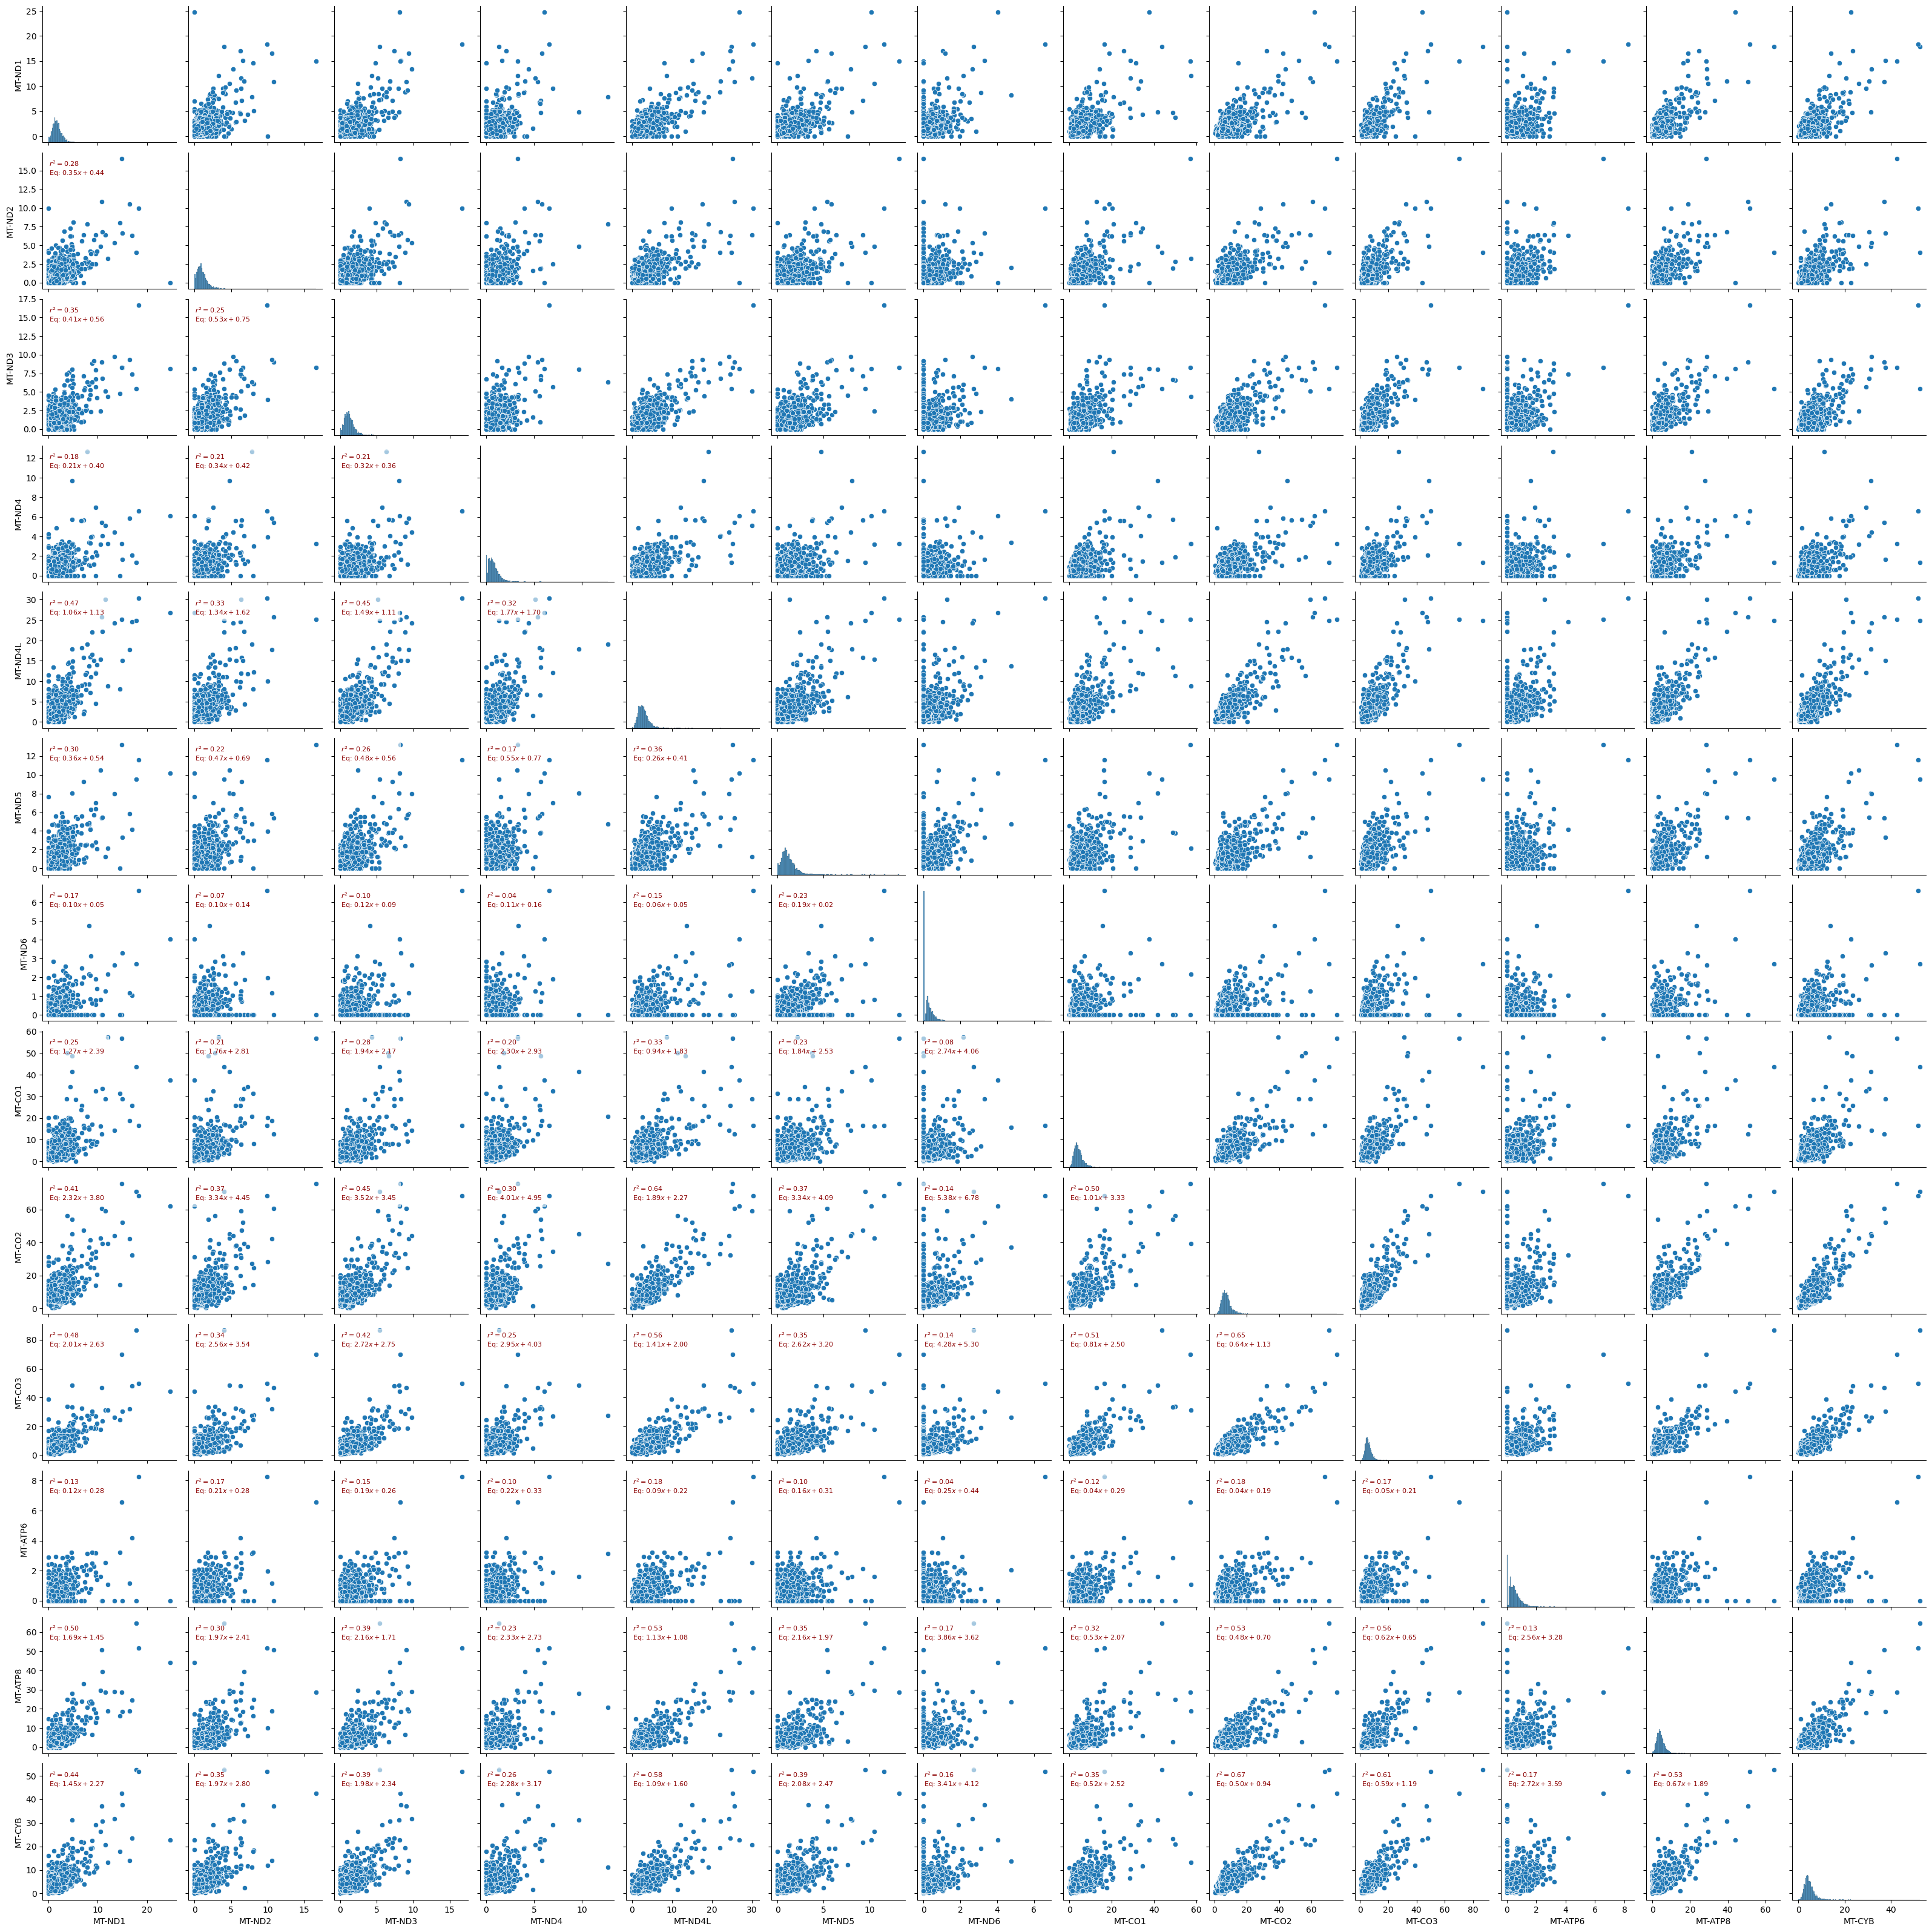

In [47]:
sns.pairplot(p14_intnon_n3).map_lower(r2)
plt.show()

Partial covariance analysis

In [ ]:
x=p14_n2['MT-ND1']
r14_n2_rval=[]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    y=p14_n2[i]
    ax.set_title('p14'+''+i)
    lin_x=np.sqrt(x*y)
    lin_y=y
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red')
    r14_n2_rval.append(lin.rvalue)
    plt.show()
r14_n2_rval